In [47]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [48]:
# Load both datasets
fake_df = pd.read_csv('../Data/Fake.csv')
true_df = pd.read_csv('../Data/True.csv')

# Add labels
fake_df['label'] = 'FAKE'
true_df['label'] = 'REAL'

# Combine into one
df = pd.concat([fake_df, true_df], ignore_index=True)

# Save combined dataset
df.to_csv('../Data/fake_or_real_news.csv', index=False)

print(df['label'].value_counts())
print(df.head())
print(df.isnull().sum())

label
FAKE    23481
REAL    21417
Name: count, dtype: int64
                                               title  \
0   Donald Trump Sends Out Embarrassing New Yearâ€™...   
1   Drunk Bragging Trump Staffer Started Russian ...   
2   Sheriff David Clarke Becomes An Internet Joke...   
3   Trump Is So Obsessed He Even Has Obamaâ€™s Name...   
4   Pope Francis Just Called Out Donald Trump Dur...   

                                                text subject  \
0  Donald Trump just couldn t wish all Americans ...    News   
1  House Intelligence Committee Chairman Devin Nu...    News   
2  On Friday, it was revealed that former Milwauk...    News   
3  On Christmas day, Donald Trump announced that ...    News   
4  Pope Francis used his annual Christmas Day mes...    News   

                date label  
0  December 31, 2017  FAKE  
1  December 31, 2017  FAKE  
2  December 30, 2017  FAKE  
3  December 29, 2017  FAKE  
4  December 25, 2017  FAKE  
title      0
text       0
subject    0
d

In [49]:
print("Shape:", df.shape)

Shape: (44898, 5)


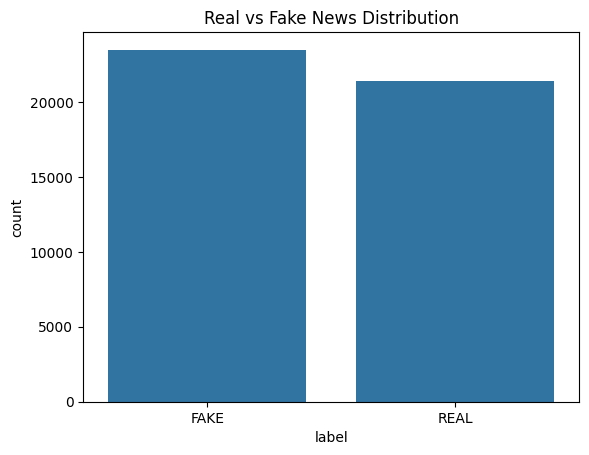

In [50]:
sns.countplot(data=df, x='label')
plt.title("Real vs Fake News Distribution")
plt.show()

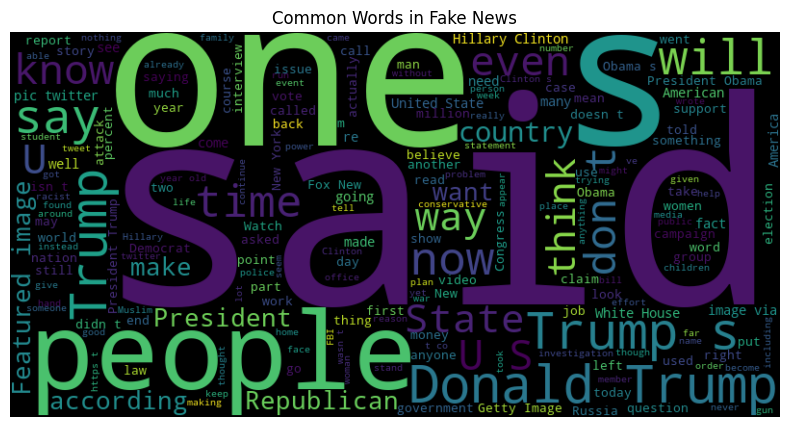

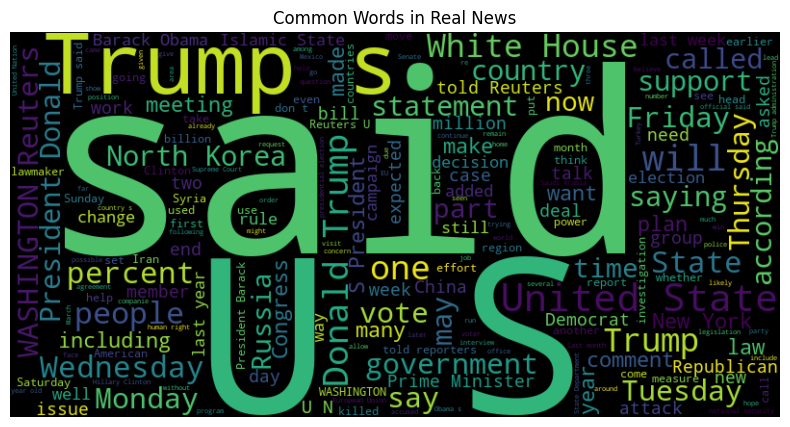

In [51]:
from wordcloud import WordCloud

# WordCloud for Fake
fake_text = " ".join(df[df['label']=='FAKE']['text'])
wordcloud_fake = WordCloud(width=800, height=400).generate(fake_text)
plt.figure(figsize=(10,5))
plt.imshow(wordcloud_fake, interpolation='bilinear')
plt.axis('off')
plt.title("Common Words in Fake News")
plt.show()

# WordCloud for Real
real_text = " ".join(df[df['label']=='REAL']['text'])
wordcloud_real = WordCloud(width=800, height=400).generate(real_text)
plt.figure(figsize=(10,5))
plt.imshow(wordcloud_real, interpolation='bilinear')
plt.axis('off')
plt.title("Common Words in Real News")
plt.show()

In [52]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer

X = df['text']
y = df['label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

vectorizer = TfidfVectorizer(stop_words='english', max_df=0.7)
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

In [53]:
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, accuracy_score

model = LogisticRegression()
model.fit(X_train_tfidf, y_train)

predictions = model.predict(X_test_tfidf)

print("Accuracy:", accuracy_score(y_test, predictions))
print(classification_report(y_test, predictions))

Accuracy: 0.9846325167037862
              precision    recall  f1-score   support

        FAKE       0.99      0.98      0.99      4733
        REAL       0.98      0.99      0.98      4247

    accuracy                           0.98      8980
   macro avg       0.98      0.98      0.98      8980
weighted avg       0.98      0.98      0.98      8980



In [54]:
y_pred = model.predict(X_test_tfidf)

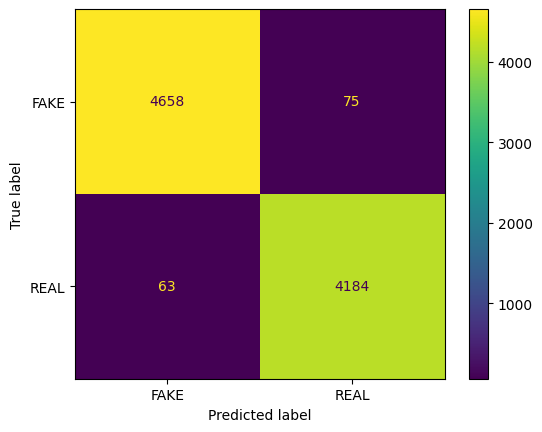

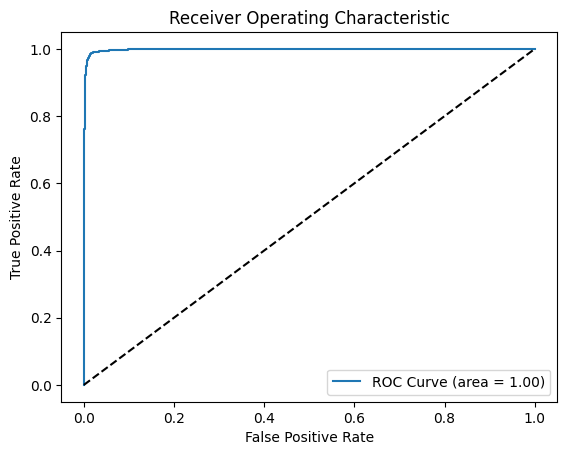

In [55]:
from sklearn.metrics import confusion_matrix, roc_curve, auc, ConfusionMatrixDisplay

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred, labels=model.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
disp.plot()
plt.show()

# ROC Curve
from sklearn.preprocessing import LabelBinarizer
lb = LabelBinarizer()
y_test_binary = lb.fit_transform(y_test).ravel()

y_proba = model.predict_proba(X_test_tfidf)[:,1]
fpr, tpr, _ = roc_curve(y_test_binary, y_proba)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, label='ROC Curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

In [56]:
from sklearn.naive_bayes import MultinomialNB

nb_model = MultinomialNB()
nb_model.fit(X_train_tfidf, y_train)
y_pred_nb = nb_model.predict(X_test_tfidf)
print("Naive Bayes Accuracy:", accuracy_score(y_test, y_pred_nb))

Naive Bayes Accuracy: 0.9327394209354121


In [57]:
from sklearn.model_selection import GridSearchCV

params = {
    'C': [0.1, 1, 10], 
    'max_iter': [100, 200]
}
grid = GridSearchCV(LogisticRegression(), param_grid=params, cv=3)
grid.fit(X_train_tfidf, y_train)
print("Best params:", grid.best_params_)

Best params: {'C': 10, 'max_iter': 100}


In [58]:
import pickle

# Save the trained model
with open('../models/fake_news_model.pkl', 'wb') as f:
    pickle.dump(model, f)
    
# Save the TF-IDF vectorizer
with open('../models/vectorizer.pkl', 'wb') as f:
    pickle.dump(vectorizer, f)

In [59]:
print(df['label'].value_counts())

label
FAKE    23481
REAL    21417
Name: count, dtype: int64


In [60]:
vector = vectorizer.transform(["BBC: Ukraine drone war"]).toarray()
print("Non-zero features:", (vector != 0).sum())

Non-zero features: 4


In [61]:
fake_df = pd.read_csv('../Data/Fake.csv')
true_df = pd.read_csv('../Data/True.csv')

fake_df['label'] = 'FAKE'
true_df['label'] = 'REAL'

df = pd.concat([fake_df, true_df])
df['headline'] = df['title']  # Use only the title (headline) column

In [62]:
df = df[['headline', 'label']].dropna()

In [63]:
from sklearn.model_selection import train_test_split

X = df['headline']
y = df['label']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [64]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(stop_words='english', max_df=0.7)
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

In [65]:
from sklearn.linear_model import LogisticRegression
model = LogisticRegression()
model.fit(X_train_tfidf, y_train)

LogisticRegression()

In [66]:
import pickle
with open('../models/fake_news_model.pkl', 'wb') as f:
    pickle.dump(model, f)
with open('../models/vectorizer.pkl', 'wb') as f:
    pickle.dump(vectorizer, f)

In [67]:
import feedparser
import pickle
from sklearn.linear_model import LogisticRegression

# Load model and vectorizer
with open('../models/fake_news_model.pkl', 'rb') as f:
    model = pickle.load(f)

with open('../models/vectorizer.pkl', 'rb') as f:
    vectorizer = pickle.load(f)

# RSS Feed URL (you can replace this)
rss_url = 'http://feeds.bbci.co.uk/news/rss.xml'
feed = feedparser.parse(rss_url)

print("\n--- ðŸ”´ LIVE NEWS FEED PREDICTIONS ðŸ”´ ---\n")

for entry in feed.entries[:10]:  # Top 10 headlines
    title = entry.title
    print(f"ðŸ”¹ Headline: {title}")

    # Vectorize headline
    vec = vectorizer.transform([title])

    # Predict label
    prediction = model.predict(vec)[0]
    proba = model.predict_proba(vec).max() * 100  # Confidence score

    print(f"ðŸ§  Prediction: {prediction}")
    print(f"ðŸŽ¯ Confidence: {proba:.2f}%\n")



--- ðŸ”´ LIVE NEWS FEED PREDICTIONS ðŸ”´ ---

ðŸ”¹ Headline: Obvious Labour leadership wants me out, Diane Abbott tells BBC
ðŸ§  Prediction: REAL
ðŸŽ¯ Confidence: 55.18%

ðŸ”¹ Headline: Kill Russians, win points: Is Ukraine's new drone scheme gamifying war?
ðŸ§  Prediction: REAL
ðŸŽ¯ Confidence: 59.87%

ðŸ”¹ Headline: Unique 1.5m year-old ice to be melted to unlock mystery
ðŸ§  Prediction: FAKE
ðŸŽ¯ Confidence: 60.06%

ðŸ”¹ Headline: Germany's Merz tells BBC Europe was free-riding on US
ðŸ§  Prediction: REAL
ðŸŽ¯ Confidence: 72.43%

ðŸ”¹ Headline: 'Trusting The Salt Path author was our biggest mistake', family says
ðŸ§  Prediction: REAL
ðŸŽ¯ Confidence: 69.02%

ðŸ”¹ Headline: Trump orders officials to 'produce' more Epstein documents after mounting pressure
ðŸ§  Prediction: REAL
ðŸŽ¯ Confidence: 86.86%

ðŸ”¹ Headline: South East hosepipe ban affecting more than 1.4 million customers comes into force
ðŸ§  Prediction: REAL
ðŸŽ¯ Confidence: 66.69%

ðŸ”¹ Headline: The Late Show with Steph